In [8]:
from pathlib import Path
from pqdm.processes import pqdm
import numpy as np
import matplotlib.pyplot as plt
import mne


mne.set_log_level(verbose='WARNING')

N_JOBS = 7  # Should match the number of your (high-performance) CPU cores

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
subjects = [
    '04', '06','07','08','09', '13','14','15','16','18','19',
    '20','21','22','23','24','25','26','27','28','29','30','32'
]

contrast = ['Cond == 2', 'Cond == 4']


def read_cleaned_epochs(subject):
    # Import epochs
    meg_subject_dir = Path(f'lb_analysis_sparse/import_metadata/sub-{subject}/meg/')
    filename = f'sub-{subject}_task-sparse_metadata_proc-clean_epo.fif'
    epochs_path = meg_subject_dir / filename

    epochs = mne.read_epochs(epochs_path)
    return epochs


def compute_evoked_contrast(subject):
    # Read epochs
    epochs = read_cleaned_epochs(subject)

    # Compute evokeds
    evokeds = [
        epochs[contrast[0]].average(),
        epochs[contrast[1]].average()
    ]

    # Contrast the evokeds
    evoked_contrast = mne.combine_evoked(evokeds, weights=[1, -1])

    return evoked_contrast


evoked_contrasts_all_subjects = pqdm(
    subjects,
    function=compute_evoked_contrast,
    n_jobs=1
)

print(f'Calculated {len(evoked_contrasts_all_subjects)} contrasts!')

  0%|          | 0/23 [00:00<?, ?it/s]

Calculated 23 contrasts!


In [4]:
ch_type = 'mag'  # we only use magnetometers – data was Maxwell-filtered
tmin = 0
tmax = None  # end of the evoked

all_evoked_contrasts_cropped = []
all_data = []

for evoked_contrast in evoked_contrasts_all_subjects:
    evoked_contrast_cropped = (
        evoked_contrast
        .copy()  # don't modify the original!
        .crop(tmin=tmin, tmax=tmax)
        .pick(ch_type)
    )
    all_evoked_contrasts_cropped.append(evoked_contrast_cropped)

    data = evoked_contrast_cropped.data.T  # transpose to have time on the first axis
    all_data.append(data)

    del evoked_contrast_cropped, data  # so we don't accidentally re-use it later!

all_data = np.array(all_data)

# get measurement info from first participant
info = all_evoked_contrasts_cropped[0].info
times = all_evoked_contrasts_cropped[0].times

# compute adjacency
adjacency, ch_names = mne.channels.find_ch_adjacency(info=info, ch_type=ch_type)

all_data.shape, adjacency.shape, times.shape

((23, 32, 102), (102, 102), (32,))

In [5]:
all_data[0].shape

(32, 102)

In [42]:
from mne.stats import permutation_cluster_1samp_test, spatio_temporal_cluster_1samp_test

# n_permutations = 2**12
n_permutations = 2**13
# n_permutations = 'all'
tail = 0
threshold = None

cluster_stats = spatio_temporal_cluster_1samp_test(
    X=all_data,
    threshold=threshold,
    n_jobs=N_JOBS,
    tail=tail,
    n_permutations=n_permutations,
    adjacency=adjacency,
    out_type='mask',
    seed=42,  # make results reproducible
    verbose=True,
)

T_obs, clusters, p_values, _ = cluster_stats

Using a threshold of 2.073873
stat_fun(H1): min=-3.585704 max=4.689721
Running initial clustering
Found 27 clusters
Permuting 8191 times...


  0%|          |  : 0/8191 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [43]:
len(clusters)

27

In [44]:
len(p_values)

27

In [45]:
p_threshold = 0.05
significant_clusters_indices = np.where(p_values < p_threshold)[0]  # don't forget the [0]
significant_clusters_indices

array([5])

In [46]:
significant_clusters = []

for cluster_index in significant_clusters_indices:
    significant_clusters.append(clusters[cluster_index])

significant_clusters

[array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])]

In [50]:
significant_clusters[0].shape

(32, 102)

In [54]:
import pandas as pd

cluster_df = pd.DataFrame(
    significant_clusters[0],
    columns=all_evoked_contrasts_cropped[0].ch_names,
    index=pd.Index(times, name='time')
)
cluster_df.to_clipboard()

Text(0, 0.5, 'T-value')

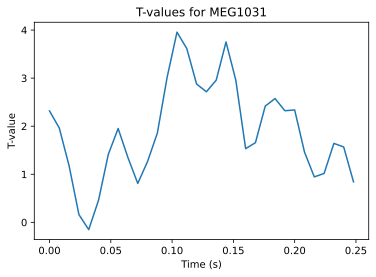

In [61]:
ch_name = 'MEG1031'
ch_idx = (
    all_evoked_contrasts_cropped[0]
    .ch_names
    .index(ch_name)
)

fig, ax = plt.subplots()
ax.plot(times, T_obs[:, ch_idx])
ax.set_title(f'T-values for {ch_name}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('T-value')

In [100]:
cluster_df_cleaned = (
    cluster_df[cluster_df]
    .dropna(how='all', axis='columns')
    .dropna(how='all', axis='index')
)
cluster_df_cleaned

,MEG0221,MEG0321,MEG0331,MEG0411,MEG0421,MEG0431,MEG0441,MEG0531,MEG0611,MEG0621,...,MEG1111,MEG1121,MEG1131,MEG1141,MEG1231,MEG1241,MEG1311,MEG1341,MEG1821,MEG2421
time,,,,,,,,,,,,,,,,,,,,,
0.064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,NaN,NaN,NaN,NaN,True,NaN,NaN
0.072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,True,NaN,True,True,True,True,NaN,NaN
0.080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,True,NaN,True,True,NaN,NaN,NaN,NaN
0.088,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,...,True,True,True,True,NaN,NaN,NaN,NaN,True,NaN
0.096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,NaN,True,True,True,NaN,NaN
0.104,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,True,...,True,True,True,NaN,NaN,True,True,True,NaN,True
0.112,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,True,...,True,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
0.120,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
0.128,NaN,NaN,True,True,True,NaN,True,NaN,True,True,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN


In [106]:
cluster_channels = cluster_df_cleaned.columns
cluster_times = cluster_df_cleaned.index

In [82]:

channel_layout = mne.find_layout(info, ch_type=ch_type)
channel_layout

<Layout | Vectorview-mag - Channels: MEG0111, MEG0121, MEG0131 ...>

In [107]:
channel_positions = channel_layout.pos
channel_positions.shape

(102, 4)

In [102]:
T_obs.shape

(32, 102)

In [134]:
time_indices = np.where((times >= cluster_times[0]) & (times <= cluster_times[-1]))[0]
time_indices

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [138]:
channel_indices = np.array([
    all_evoked_contrasts_cropped[0].ch_names.index(ch_name)
    for ch_name in cluster_channels
])
channel_indices

array([ 5,  9, 10, 12, 13, 14, 15, 18, 20, 21, 22, 23, 24, 25, 28, 29, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 49, 67, 91])

In [125]:
len(channel_indices)

32

In [142]:
T_obs[time_indices,:][:,channel_indices]

(12, 32)

In [136]:
time_indices

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [159]:
channel_indices

array([ 5,  9, 10, 12, 13, 14, 15, 18, 20, 21, 22, 23, 24, 25, 28, 29, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 49, 67, 91])

In [169]:
T_vals_cluster = T_obs[time_indices, :]
T_vals_cluster.shape

(12, 102)

In [170]:
T_vals_cluster_time_average = T_vals_cluster.mean(axis=0)
T_vals_cluster_time_average.shape

(102,)

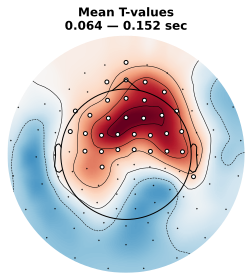

In [206]:
channel_mask = np.array(
    [ch_name in cluster_channels
     for ch_name in info.ch_names],
    dtype='bool'
)


fig, ax = plt.subplots()
ax.set_title(
    f'Mean T-values\n{cluster_times[0]} — {cluster_times[-1]} sec',
    fontweight='bold'
)

mne.viz.plot_topomap(
    data=T_vals_cluster_time_average,
    pos=info,
    extrapolate="head",
    mask=channel_mask,
    ch_type=ch_type,
    axes=ax
);


Text(0.5, 1.0, 'Mean of 32 channels in cluster')

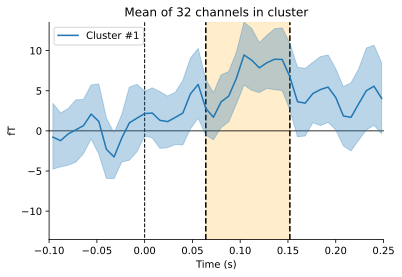

In [242]:
fig, ax = plt.subplots()

mne.viz.plot_compare_evokeds(
    evokeds={
        'Cluster #1': evoked_contrasts_all_subjects
    },
    picks=cluster_channels.to_list(),
    combine='mean',
    axes=ax,
    truncate_yaxis=False,
    truncate_xaxis=False,
    show=False
)
ax.fill_betweenx(ax.get_ylim(), cluster_times[0], cluster_times[-1], color='orange', alpha=0.2)
ax.axvline(cluster_times[0], ls='--', color='black')
ax.axvline(cluster_times[-1], ls='--', color='black')
ax.set_title(f'Mean of {len(cluster_channels)} channels in cluster')


In [220]:
len(cluster_channels)

32